In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score

import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import warnings
warnings.filterwarnings('ignore')

### Without Time Series

In [ ]:
#Importing Data
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/address_data_combined.csv')
X = df.drop(columns=['Address', 'FLAG'])
X.head()

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
0,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,0.000000,8,0.040100,0.040100
1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,0.419270,22,2.650000,-0.284889
2,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,2.499538,3,4.999916,0.000840
3,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,2.084658,22,2.085000,0.000342


In [ ]:
X.shape

(14155, 12)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14155 entries, 0 to 14154
Data columns (total 12 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Avg min between sent tnx                              14155 non-null  float64
 1   Avg min between received tnx                          14155 non-null  float64
 2   Time Diff between first and last (Mins)               14155 non-null  float64
 3   Unique Received From Addresses                        14155 non-null  int64  
 4   min value received                                    14155 non-null  float64
 5   max value received                                    14155 non-null  float64
 6   avg val received                                      14155 non-null  float64
 7   min val sent                                          14155 non-null  float64
 8   avg val sent                                          14

In [ ]:
y = df['FLAG']
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance']

scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
logreg = LogisticRegression()

parameters = {
    'penalty' : ['l1','l2'],
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',        # metric for scoring
                   cv=10)                     # number of folds

start_time = time.time()
clf.fit(X_train_full ,y_train_full)
print(time.time() - start_time)

178.69180631637573


In [ ]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Train F1 Score :",clf.best_score_)
best_y_pr = clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'C': 1000.0, 'penalty': 'l2', 'solver': 'lbfgs'}
Train F1 Score : 0.8356468258800731
Test F1 Score:  0.8360406091370559


In [ ]:
logreg = LogisticRegression(C=1000,penalty="l1",solver='liblinear')
logreg.fit(X_train_full,y_train_full)
y_pred = logreg.predict(X_test)

print("F1 Score: {}\nRecall: {}\nAccuracy: {}\nPrecision: {}\nROC AUC: {}".format(
    f1_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    roc_auc_score(y_test, y_pred))
)

F1 Score: 0.8360406091370559
Recall: 0.8420245398773006
Accuracy: 0.8478926300918296
Precision: 0.8301411290322581
ROC AUC: 0.8474636012350274


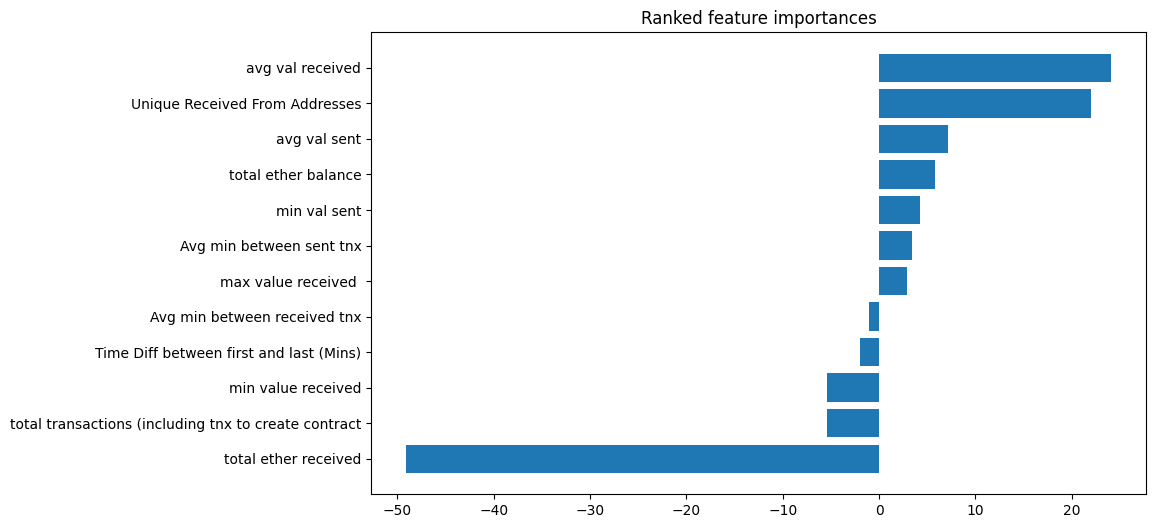

In [ ]:
feat_importances = clf.best_estimator_.coef_[0]
indices = np.argsort(feat_importances)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

### With Time Series

In [ ]:
#Importing Data
df = pd.read_csv('/content/drive/MyDrive/ethereum-fraud-detection/data/address_data_combined_ts.csv')
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

X.head()

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,...,adjusted_eth_value__absolute_sum_of_changes,adjusted_eth_value__mean_abs_change,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,adjusted_eth_value__sum_values,adjusted_eth_value__abs_energy,adjusted_eth_value__ratio_value_number_to_time_series_length,adjusted_eth_value__quantile__q_0.1,adjusted_eth_value__count_below__t_0,adjusted_eth_value__count_above__t_0,adjusted_eth_value__median
0,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,0.000000,8,...,0.129900,0.008119,0.358576,0.032100,0.001400,0.470588,-0.000000,0.647059,0.941176,0.000
1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,0.419270,22,...,7.669778,0.365228,0.020237,-0.284889,3.335466,0.409091,-0.267421,0.363636,0.681818,0.150
2,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,2.499538,3,...,7.508992,3.754496,0.666738,0.000840,37.494722,1.000000,-2.505261,0.666667,0.333333,-2.490
3,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000
4,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,2.084658,22,...,3.404658,0.162127,0.006660,0.000342,4.594823,0.409091,0.050000,0.045455,0.954545,0.085


In [ ]:
X.shape

(13920, 22)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13920 entries, 0 to 13919
Data columns (total 22 columns):
 #   Column                                                                        Non-Null Count  Dtype  
---  ------                                                                        --------------  -----  
 0   Avg min between sent tnx                                                      13920 non-null  float64
 1   Avg min between received tnx                                                  13920 non-null  float64
 2   Time Diff between first and last (Mins)                                       13920 non-null  float64
 3   Unique Received From Addresses                                                13920 non-null  int64  
 4   min value received                                                            13920 non-null  float64
 5   max value received                                                            13920 non-null  float64
 6   avg val received              

In [ ]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance','adjusted_eth_value__absolute_sum_of_changes',
     'adjusted_eth_value__mean_abs_change',
     'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
     'adjusted_eth_value__sum_values',
     'adjusted_eth_value__abs_energy',
     'adjusted_eth_value__ratio_value_number_to_time_series_length',
     'adjusted_eth_value__quantile__q_0.1',
     'adjusted_eth_value__count_below__t_0',
     'adjusted_eth_value__count_above__t_0',
     'adjusted_eth_value__median']

scaler = MinMaxScaler()

# Log for Skewed Data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
logreg = LogisticRegression()
parameters = {
    'penalty' : ['l1','l2'],
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='f1',        # metric for scoring
                   cv=10)                     # number of folds
start_time = time.time()
clf.fit(X_train_full ,y_train_full)
print(time.time() - start_time)

442.2119793891907


In [ ]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Train F1 Score :",clf.best_score_)
best_y_pr = clf.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
Train F1 Score : 0.8503255143569527
Test F1 Score:  0.8523975354942406


In [ ]:
logreg = LogisticRegression(C=1000,penalty="l1",solver='liblinear')
logreg.fit(X_train_full,y_train_full)
y_pred = logreg.predict(X_test)

print("F1 Score: {}\nRecall: {}\nAccuracy: {}\nPrecision: {}\nROC AUC: {}".format(
    f1_score(y_test, y_pred),
    recall_score(y_test, y_pred),
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    roc_auc_score(y_test, y_pred))
)


F1 Score: 0.852169255490091
Recall: 0.8440318302387267
Accuracy: 0.867816091954023
Precision: 0.8604651162790697
ROC AUC: 0.8657086257260853


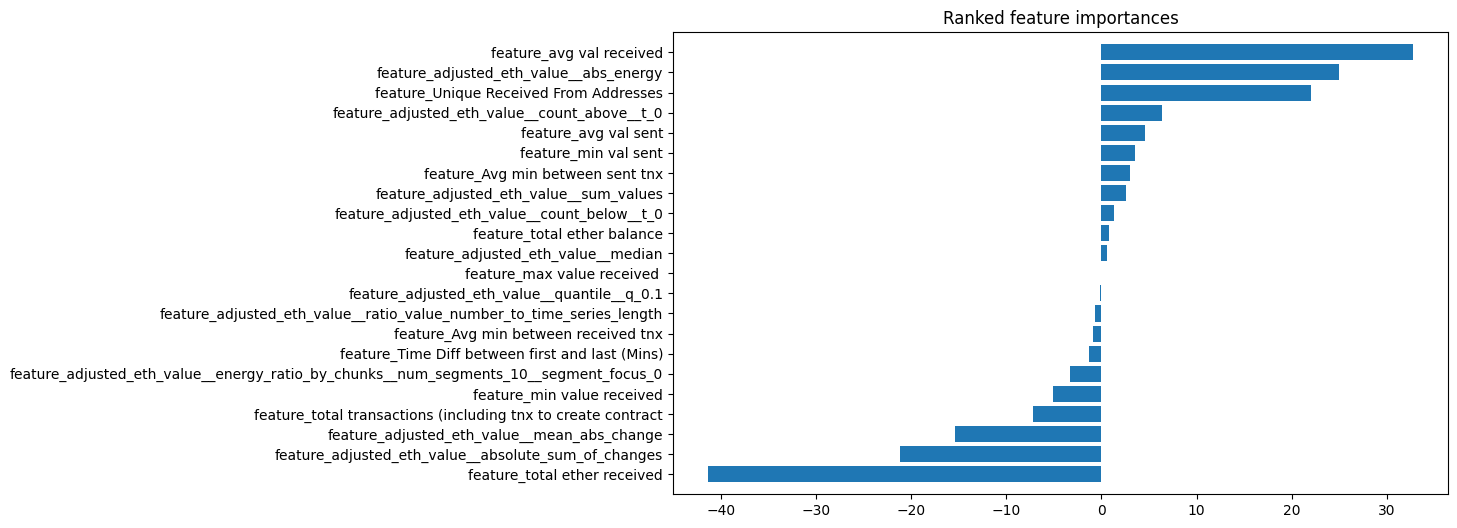

In [ ]:
feat_importances = clf.best_estimator_.coef_[0]
indices = np.argsort(feat_importances)

# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(columns[i]) for i in range(len(columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();